In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import seaborn as sns
import torch
from torch import nn
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data_points, data_labels):
        self.data_points = data_points
        self.data_labels = data_labels

    def __len__(self):
        return len(self.data_labels)

    def __getitem__(self, idx):
        return self.data_points[idx], self.data_labels[idx]

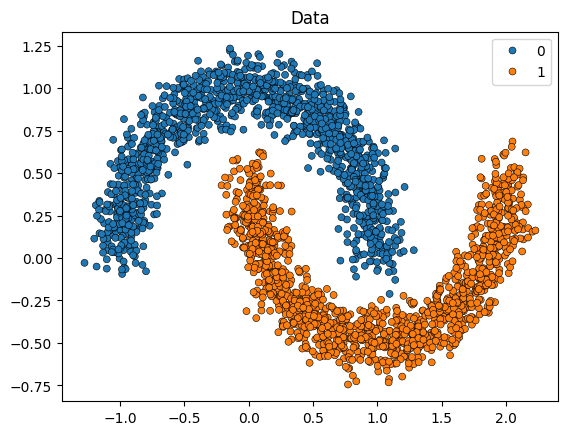

In [3]:
amount = 2500
points, labels = make_moons(n_samples=amount, shuffle=True, noise=0.1, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.3, random_state=0)

# my_moons = CustomDataset(points, labels)
train_set = CustomDataset(X_train, y_train)
test_set = CustomDataset(X_test, y_test)

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=labels, marker="o", s=25, edgecolor="k", legend=True
).set_title("Data")
plt.show()

X = torch.from_numpy(points).to(dtype=torch.float32)
y = torch.from_numpy(labels).to(dtype=torch.float32)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
def flatten_tuples(list_of_tuples):
    new_list = []
    for row in list_of_tuples:
        if isinstance(row, tuple):
            for item in row:
                    new_list.append(item)
        else:
            new_list.append(row)
    # return [item for row in matrix for item in row]
    return new_list

In [6]:
class Empty(nn.Module):
    def __init__(self, num):
        super().__init__()

    def forward(self, x):
        return x

class MLP(nn.Module):
    def __init__(self, data_size, layers_sizes, normalizes_input, dropouts_input, activations):
        super().__init__()
        # self.flatten = nn.Flatten()
        torch.manual_seed(2)
        all_sizes = [data_size] + layers_sizes
        tuples_for_linear = [(all_sizes[i], all_sizes[i+1]) for i in range(len(all_sizes) - 1)]
        
        normalizes = [nn.BatchNorm1d(s) if norm else Empty(s) for norm, s in zip(normalizes_input, layers_sizes[:-1])]
        dropouts = [nn.Dropout(drop) for drop in dropouts_input]
        
        all_instructions = list(zip(tuples_for_linear[:-1], normalizes, dropouts, activations))
        all_instructions.append(tuples_for_linear[-1])
        
        # print(all_instructions)

        modules = flatten_tuples([(nn.Linear(i[0][0], i[0][1]), i[1], i[2], i[3]) for i in all_instructions[:-1]] + [nn.Linear(all_instructions[-1][0], all_instructions[-1][1])])
        # print(modules)
        
        self.stack = nn.Sequential(*modules)  # thanks allenye0119 of https://discuss.pytorch.org/t/append-for-nn-sequential-or-directly-converting-nn-modulelist-to-nn-sequential/7104
        
    def forward(self, x):
        # x = self.flatten(x)
        logits = self.stack(x)
        return logits

In [7]:
model = MLP(X.shape[1], [10, 20, 10, 1], [1, 1, 1], [0.1, 0, 0], [nn.ReLU(), nn.ReLU(), nn.ReLU()]).to(device)

In [8]:
model.stack

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.1, inplace=False)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=20, bias=True)
  (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0, inplace=False)
  (7): ReLU()
  (8): Linear(in_features=20, out_features=10, bias=True)
  (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Dropout(p=0, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=10, out_features=1, bias=True)
)

In [9]:
# model.linear_relu_stack

In [10]:
learning_rate = 0.0005
batch_size = 200

# loss_func = nn.BCELoss()
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
my_moons_dataloader = DataLoader(train_set, batch_size=200, shuffle=True)

In [11]:
# print(list(my_moons_dataloader)[0])

In [12]:
def training_loop(dataloader, model, loss_func, optimizer, epochs):
    loss_after_epoch = []
    loss_list = []
    size = len(dataloader.dataset)
    model.train()
    for i in range(epochs):
        for batch, (XX, yy) in enumerate(dataloader):
            optimizer.zero_grad()
            predict = model(XX.float()).flatten()
            loss = loss_func(predict, yy.float())
            
            loss_list.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
            # if batch%10 == 0:
            #     print(f'Batch {batch}')
            
        # if i%10 == 0:
        #     print(f"loss: {loss.item():>7f}")
        
        print(f"loss: {loss.item():>7f}")

        loss_after_epoch.append(loss.item())
        
    plt.plot(loss_list)
    plt.show()
    plt.plot(loss_after_epoch)
    plt.show()

loss: 0.676457
loss: 0.638433
loss: 0.641770
loss: 0.575883
loss: 0.576289
loss: 0.580037
loss: 0.533228
loss: 0.529359
loss: 0.498740
loss: 0.475145
loss: 0.493946
loss: 0.466852
loss: 0.484568
loss: 0.472993
loss: 0.432869
loss: 0.419960
loss: 0.423032
loss: 0.409740
loss: 0.391086
loss: 0.381881
loss: 0.434763
loss: 0.392445
loss: 0.370120
loss: 0.371385
loss: 0.325170
loss: 0.363272
loss: 0.325668
loss: 0.343824
loss: 0.343919
loss: 0.296669
loss: 0.312453
loss: 0.306541
loss: 0.278513
loss: 0.254840
loss: 0.268204
loss: 0.248582
loss: 0.241861
loss: 0.255690
loss: 0.255311
loss: 0.259325
loss: 0.256888
loss: 0.219272
loss: 0.218864
loss: 0.227076
loss: 0.200657
loss: 0.193080
loss: 0.187590
loss: 0.194758
loss: 0.181008
loss: 0.199454
loss: 0.170280
loss: 0.172531
loss: 0.167770
loss: 0.182881
loss: 0.173742
loss: 0.139065
loss: 0.150999
loss: 0.137706
loss: 0.135706
loss: 0.137130
loss: 0.129939
loss: 0.142389
loss: 0.118740
loss: 0.146860
loss: 0.123504
loss: 0.111968
loss: 0.10

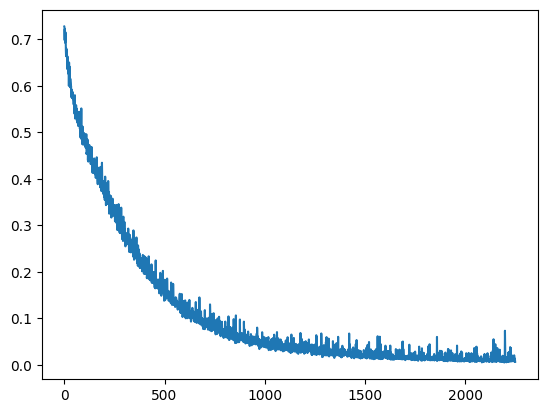

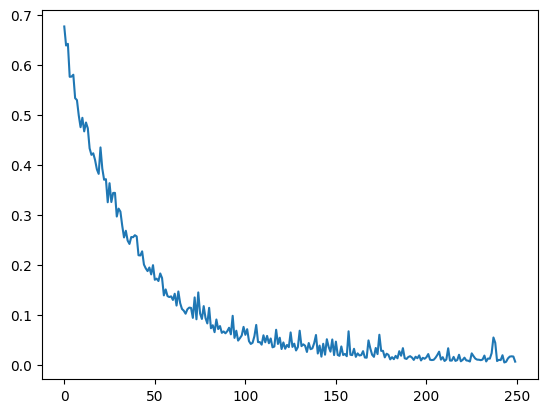

In [13]:
training_loop(my_moons_dataloader, model, loss_func, optimizer, 250)

98.19414094090462% accurate


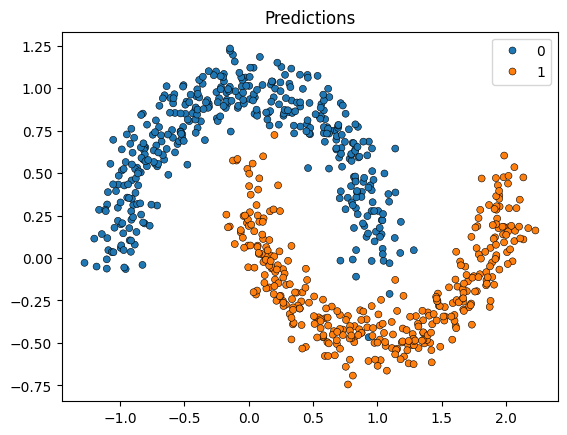

In [14]:
predictions = model(torch.Tensor(X_test)).sigmoid()

loss_func = nn.BCELoss()
print(f"{(1 - loss_func(predictions.flatten(), torch.Tensor(y_test)).item())*100}% accurate")

predictions = predictions.detach().numpy().flatten()
predictions = (predictions > 0.5).astype(int)
sns.scatterplot(
    x=X_test[:, 0], y=X_test[:, 1], hue=predictions, marker="o", s=25, edgecolor="k", legend=True
).set_title("Predictions")
plt.show()